# Implementação do Algoritmo das Projeções Sucessivas

O algoritmo busca identificar as variáveis mais relevantes para um problema de regressão linear múltipla a partir da eliminação das variáveis com informação redundante.

O critério de eliminação das variáveis é a sua colinearidade em relação a outras variáveis, o que é calculado a partir da projeção da primeira em subespaços osrtogonais às últimas.

Os trabalhos utilizados como base para esta implementação são:

>   _M. C. U. Araújo, T. C. B. Saldanha, R. K. H. Galvão, T. Yoneyama, H. C. Chame and V. Visani, “The Successive     Projections Algorithm for Variable Selection in Spectroscopic Multicomponent”, Chemometrics and Intelligent Laboratory   Systems, Vol. 57, No. 2, p. 65-73, 2001._ 

> GUI do Algoritmo das Projeções Sucessivas, disponível em http://www.ele.ita.br/~kawakami/spa

### Progresso:

<input type="checkbox" checked> Implementar projeções com decomposição QR

<input type="checkbox" unchecked> Refazer implementação das outras funções utilizando apenas np.array para poder usar o numba

<input type="checkbox" unchecked> Comparar desempenho com a implementação anterior

### Notas:

- Projeções com decomposição QR chegaram a ser 260 vezes mais rápidas do que com as rotinas originais (com k0=0 e N=5, rotinas originais levaram 1.3 segundos e QR levou 0.005 segundos). Os resultados foram iguais.

---

## Bibliotecas utilizadas

In [1]:
# Versões das bibliotecas usadas estão listadas no arquivo requirements.txt

import numpy as np
import matplotlib.pyplot as plt
import scienceplots
import pandas as pd
from scipy.linalg import qr
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from tqdm import tqdm
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from scipy.io import loadmat
from sklearn.metrics.pairwise import pairwise_distances
from kennard_stone import train_test_split

In [2]:
# Configuração do estilo do plot
plt.style.use(['grid', 'science', 'notebook'])

---

## Funções desenvolvidas

In [3]:
def projections_qr(X, k, M):
    """Projeções sucessivas das colunas de X em subespaços ortogonais, partindo da coluna
    k e selecionando M colunas ao fim do processo. Referente à Fase 1 do APS.
    
    Essa implementação utiliza a decomposição QR com pivotação de colunas como um "atalho",
    pois é realizado o mesmo processo de busca do APS, mas de forma otimizada. 
    
    Input:
            X --> matriz numpy com dados de calibração \n
            k --> índice da coluna a ser utilizada como vetor de referência inicial \n
            M --> número máximo de variáveis a ser selecionadas \n
            
    Output:
            SEL --> vetor com índice das colunas referentes às variáveis selecionadas            
    """
    
    # Nessa implementação, não é necessário armazenar o X projetado. Apenas
    # escala-se a coluna referente a k para que ela seja o primeiro vetor de 
    # referência na decomposição QR
    X_scaled = X.copy()
    
    # Determina a norma euclidiana de cada coluna de X
    norms = np.sum((X ** 2), axis=0)
    
    # Determina a norma máxima entre as colunas
    norm_max = np.amax(norms)
    
    # Por padrão, a decomposição QR inicia com a coluna de maior norma. Por
    # isso, faz-se a coluna referente a k ter norma duas vezes maior que a 
    # coluna com maior norma para ela ser o primeiro vetor de referência
    X_scaled[:, k] = X_scaled[:, k] * 2 * norm_max / norms[k]
    
    # Na decomposição QR com pivotação de colunas, o vetor de referência em
    # cada iteração é escolhido como aquele com maior norma euclidiana, da
    # mesma forma que o APS é definido.
    #
    # A função qr() do scipy.linalg, quando utilizada com pivotação, retorna
    # como terceiro output o vetor de permutações P, que armazena os índices
    # das variáveis utilizadas como referência em cada iteração. Desse modo,
    # as M primeiras variáveis em P são exatamente as mesmas que seriam
    # selecionadas pelo APS
    _, __, reference_variables = qr(X_scaled, 0, pivoting=True)
    SEL = reference_variables[:M].T
    return SEL

In [32]:
def standardize_data(X):
    """Padroniza a distribuição dos dados da matriz de calibração, que é assumida como normal. Isso permite que apenas
    o ângulo entre os vetores seja determinante para a seleção de variáveis.

    Inputs:
            X --> matriz numpy com os dados de calibração

    Outputs: 
            X_standardized --> matriz numpy com os dados padronizados (média 0 e desvio-padrão 1)
    """

    X_standardized = X.copy()

    # Realiza-se a padronização em cada coluna de X (subtrai a média e divide pelo desvio-padrão)
    for col in range(X.shape[1]):
        X_standardized[:, col] = (X[:, col] - np.mean(X[:, col], axis=0)) / np.std(X[:, col], axis=0)

    return(X_standardized)


In [55]:
def validate(xcal, ycal, SEL, xval=None, yval=None):
    """Avalia qualidade do modelo obtido com o conjunto de variáveis selecionadas. 
    
    Inputs:
            xcal, ycal --> matrizes numpy com dados para calibração \n
            xval, yval (default=None) --> matrizes numpy com dados para validação. Se não especificadas,
                                        será utilizada a validação cruzada por LOO \n
            SEL --> índices das colunas de X selecionadas na Fase 1 do algoritmo \n
            
    Outputs: 
            RMSE --> erro do modelo
    """
    
    # Número de amostras de calibração
    N = xcal.shape[0]  
    
    # Determina se deve ser usado o conjunto de validação ou LOO
    if xval is None:  
        N_val = 0
    else:
        N_val = xval.shape[0]
    
    # Se há conjunto de validação especificado, usa ele para a validação
    if N_val > 0:        
        # Regressão linear múltipla
        xcal_augmented = np.hstack([np.ones((N, 1)), xcal[:, SEL].reshape(N, -1)])
        w = np.linalg.lstsq(xcal_augmented, ycal, rcond=None)[0]
        # Previsões no conjunto de validação
        xval_augmented = np.hstack([np.ones((N_val, 1)), xval[:, SEL].reshape(N_val, -1)])
        yhat = xval_augmented.dot(w)
        
        # Cálculo do RMSE
        RMSE = np.sqrt(np.mean((yval-yhat)**2, axis=0))
        
    # Se não há conjunto de validação, usa-se LOO no conjunto de calibração    
    else:
        # Define o tamanho adequado para yhat
        yhat = np.zeros((N, 1))
        
        # A cada iteração, seleciona-se uma amostra do conjunto de calibração para servir de
        # validação e constrói-se o modelo com todas as demais amostras (LOOCV - Leave-One-Out Cross-Validation)
        for i in range(N):
            # Remove o item i do conjunto de calibração e usa ele como validação
            cal = np.hstack([np.arange(i), np.arange(i + 1, N)])
            xcal_loo = xcal[cal, :][:, SEL]
            ycal_loo = ycal[cal]
            xval_loo = xcal[i, SEL]
            
            # Regressão linear múltipla
            xcal_loo_augmented = np.hstack([np.ones((N - 1, 1)), xcal_loo.reshape(N - 1, -1)])
            w = np.linalg.lstsq(xcal_loo_augmented, ycal_loo, rcond=None)[0]
                
            # Previsão na amostra de validação
            yhat[i] = np.hstack([np.ones(1), xval_loo]).dot(w)
            
        # Cálculo do RMSE do LOO
        RMSE = np.sqrt(np.mean((ycal-yhat.flatten())**2, axis=0))

    return(RMSE)


In [ ]:
def hiperpar(xcal, ycal, xval, yval, M_min, M_max):
    '''Seleção dos hiperparâmetros do APS. Referente à Fase 2 do algoritmo.
    
    Input:
            xcal, ycal --> matrizes numpy com dados para calibração \n
            xval, yval --> matrizes numpy com dados para validação \n
            M_min, M_max --> número mínimo e máximo de variáveis no conjunto final \n

    Output:
            Nstar = valor ótimo para N
            k0star = valor ótimo para k0'''
            
    mlr = linear_model.LinearRegression()
    
    # Número máximo e mínimo de variáveis no conjunto ótimo
    Nvec = np.arange(Nmin, Nmax + 1, 1)
    
    # Conjunto dos RMSEs (um pra cada k0)
    rho = pd.DataFrame(columns=['N', 'k0', 'RMSE'])
    
    # Conjunto dos RMSES (um pra cada N)
    rs = rho.copy()
    
    # Melhor N e k0
    sol = rho.copy()
    
    for N in tqdm(Nvec):
        
        # Reseta rho
        rho = rho.drop(rho.index)
        
        for k0 in xcal:
            k = aps(xcalNorm, N, k0)
            
            # Obtenção do modelo de MLR
            xtrain = xcal[k].values
            ytrain = ycal.values
            mlr.fit(xtrain, ytrain)
            
            # Teste do modelo 
            xtest = xval[k].values
            ytest = yval.values
            yhat = mlr.predict(xtest)
            RMSE = np.sqrt(np.mean((ytest-yhat)**2, axis=0))
            
            # Atualização do conjunto de RMSEs pra cada k0
            RMSEaux = pd.DataFrame({'N':[N], 'k0':k0, 'RMSE':RMSE})
            rho = pd.concat([rho, RMSEaux], axis=0)
            
        # Atualização do conujunto de N e k0 que retornaram RMSE mínimo
        rho = rho.reset_index(drop=True)
        rs = pd.concat([rs, np.transpose(pd.DataFrame(rho.loc[rho['RMSE'].idxmin()]))], axis=0)
    
    # Obtenção do N* e k0* (valores ótimos)
    rs['RMSE'] = pd.to_numeric(rs['RMSE'])
    rs = rs.reset_index(drop=True)
    min = np.transpose(pd.DataFrame(rs.loc[rs['RMSE'].idxmin()]))
    sol = pd.concat([sol, min], axis=0)
    Nstar = sol['N'].values
    k0star = sol['k0'].values
    
    return (Nstar, k0star)

In [ ]:
def spa():
    
    # Fase 1: Cálculo das projeções para cada par (k, M)
    
    # Fase 2: Grid-search para obter par (k, M) que produz o melhor modelo
    
    # Fase 3: Eliminação de variáveis com pouca relevância

---

## Teste com dados de quimiometria sugeridos pelos autores do APS

Originalmente, o método foi proposto como uma forma de selecionar **comprimentos de onda relevantes** para análises espectroscópicas. Nesse tipo de análise, mede-se a intensidade de luz refletida por um corpo para cada comprimento de onda da luz, então costuma-se ter **muitos dados**. Nos dados sugeridos pelos autores do APS, cada linha corresponde à intensidade da luz em uma das 80 amostras do corpo e cada coluns representa a intensidade da luz em um dos 700 comprimentos de onda medidos. Assim, se eu plotar um comprimento de onda, vou ter 80 pontos que correspondem a medidas individuais da intensidade de luz nesse comprimento de onda. Por outro lado, se eu plotar uma amostra, vou ter 700 pontos que correspondem à intensidade de luz dessa amostra em cada comprimento de onda.

O intuito final é predizer características da amostra (umidade do milho, quantidade de amido etc.) baseado na sua resposta a diferentes comprimentos de onda, então seleciona-se os **comprimentos de onda** com menor informação redundante sobre as amostras.

In [6]:
# Os dados de entrada, 'data', são a intensidade de luz para cada comprimento de onda
#
# Os dados de saída, 'targets', são algumas propriedades da substância a serem preditas baseado na espectroscopia
# (a saber, umidade, oleosidade, proteína e amido (starch))
corn = loadmat('../Arquivos/corn.mat')
data = np.array(corn['m5spec'])
targets = np.array(corn['propvals'])

# Dados numéricos
numericData = data[0][0][7]
wavelengths = data[0][0][9][1][0][0] # Comprimentos de onda
numericTargets = targets[0][0][7]
properties = targets[0][0][8][1][0] # Propriedades a serem previstas

# Conversão para dataframe do pandas com os comprimentos de onda / propriedades sendo as colunas 
dataTable = pd.DataFrame(numericData, columns=wavelengths)
targetsTable = pd.DataFrame(numericTargets, columns=properties)

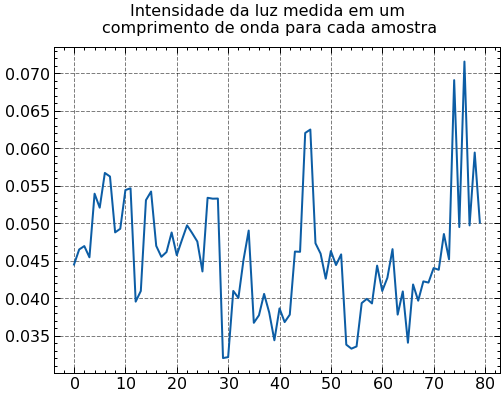

In [14]:
plt.plot(dataTable.iloc[:,0])
plt.suptitle('Intensidade da luz medida em um \ncomprimento de onda para cada amostra', fontsize=16)
plt.show()

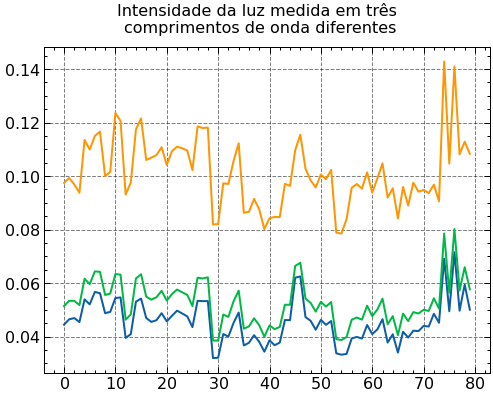

In [15]:
plt.plot(dataTable.iloc[:,[0,15,30]])
plt.suptitle('Intensidade da luz medida em três \ncomprimentos de onda diferentes', fontsize=16)
plt.show()

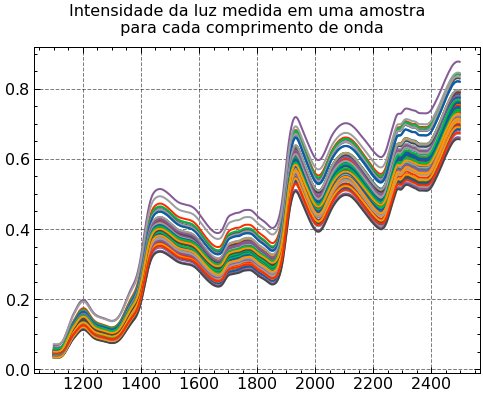

In [16]:
plt.plot(dataTable.transpose().iloc[:,:])
plt.suptitle('Intensidade da luz medida em uma amostra \n para cada comprimento de onda', fontsize=16)
plt.show()

In [36]:
SEL = projections_qr(xcal, 0, 17)

In [56]:
validate(xcal, ycal, SEL)

0.012625073622565043

In [46]:
SEL

array([  0, 696, 312, 603, 422, 553, 169,  42, 401, 576, 268, 507, 107,
       200, 385, 659, 210], dtype=int32)

Vou aplicar o APS para a seleção dos comprimentos de onda mais relevantes. Inicialmente, vou dividir os dados em calibração, validação e teste utilizando o método Kennard-Stone (KS), como sugerido no manual da GUI do APS.

In [7]:
# No manual, propõe-se usar 40 amostras pra calibração
testRatio = 0.5

# Vou utilizar implementação do pacote kennard_stone
#
# Inicialmente, vou separar em calibração e teste
xcal, xtest, ycal, ytest = train_test_split(dataTable.values, targetsTable['Moisture'].values, test_size=testRatio)
#
# Em seguida, vou separar os dados de teste em validação e teste
xval, xtest, yval, ytest = train_test_split(xtest, ytest, test_size=testRatio)


Agora, vou testar o algoritmo:

In [13]:
# Seleção dos hiperparâmetros por grid search
Nstar, k0star = hiperpar(xcal, ycal, xcalNorm, xval, yval, 1, 39)

# Seleção das variáveis menos colineares
k = aps(xcalNorm, Nstar, k0star)
k = [int(element) for element in k]
print(f'''Comprimentos de onda selecionados: {k}''')

  0%|          | 0/39 [00:00<?, ?it/s]

 15%|█▌        | 6/39 [1:07:55<8:36:24, 938.94s/it]

In [ ]:
# # A seleção de hiperparâmetros demora muito, então vou arbitrar hiperparâmetros para testar o algoritmo
# k = aps(xcalNorm, N=17, k0=0)
# k = [int(element) for element in k]
# print(f'''Comprimentos de onda selecionados: {k}''')

Comprimentos de onda selecionados: [0, 696, 114, 312, 22, 603, 160, 56, 245, 386, 422, 12, 574, 539, 131, 200, 497]


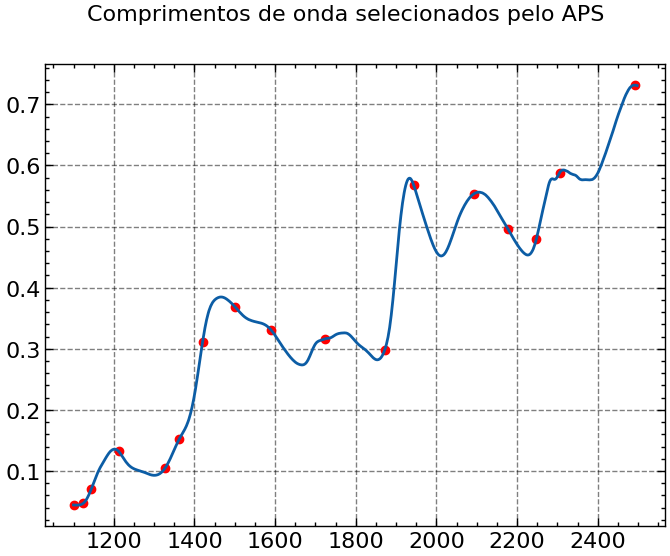

In [ ]:
plt.plot(dataTable.transpose().iloc[:,0])
plt.scatter(x=dataTable.transpose().index.values[k], 
            y=dataTable.transpose().iloc[:,0].values[k],
            marker='o', color='red')
plt.suptitle('Comprimentos de onda selecionados pelo APS', fontsize=16)
plt.show()

Por fim, vou comparar o desempenho do modelo de regressão linear múltipla com e sem o APS:

In [ ]:
# Regressão linear múltipla
mlr = linear_model.LinearRegression()
mlrAPS = linear_model.LinearRegression()

In [ ]:
# Sem APS

# Obtenção do modelo de MLR
mlr.fit(xcal, ycal)

# Teste do modelo 
yhat = mlr.predict(xtest)
RMSE = np.sqrt(np.mean((ytest-yhat)**2))

print(f'''RMSE sem APS: {round(RMSE, 5)}
Número de comprimentos de onda usados: {xcal.shape[1]}''')

RMSE sem APS: 0.00818769
Número de comprimentos de onda usados: 700


In [ ]:
# Com APS

# Obtenção do modelo de MLR
mlrAPS.fit(xcal[k], ycal)

# Teste do modelo 
yhatAPS = mlrAPS.predict(xtest[k])
apsRMSE = np.sqrt(np.mean((ytest-yhatAPS)**2))

print(f'''RMSE com APS: {round(apsRMSE, 5)}
Número de comprimentos de onda usados: {xcal[k].shape[1]}''')

RMSE com APS: 0.03729
Número de comprimentos de onda usados: 17


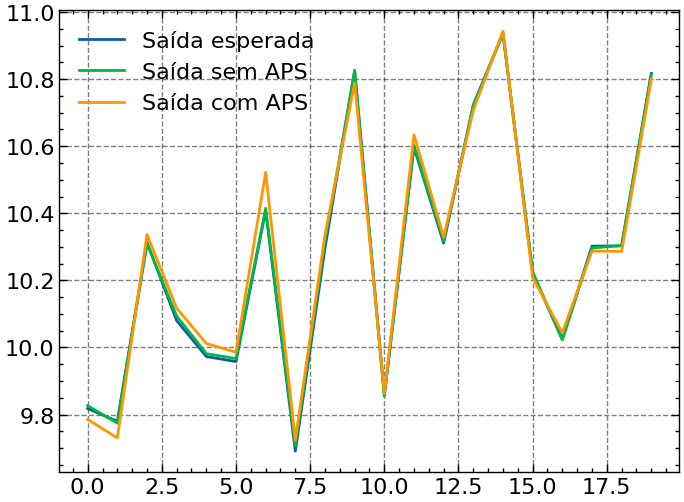

In [ ]:
plt.plot(ytest)
plt.plot(yhat)
plt.plot(yhatAPS)
plt.legend(['Saída esperada','Saída sem APS','Saída com APS'])
plt.show()

---